# Visulization -- CN vs MCI

### Import packages

In [1]:
import sys
import tensorflow as tf
import nibabel as nib

import math
from tensorflow.python.framework import ops
import pylab as py
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import matplotlib.animation as animation


import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
import h5py
import pandas as pd
import csv

import innvestigate
import innvestigate.utils as iutils
from keras.models import load_model
from keras import backend as K
from keras.utils import Sequence

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

### Some useful functions

In [2]:
def init_model(path, finetune=True, up_to=7):
    model = load_model(path)
    model.load_weights(path)
    if finetune:
        for layer in model.layers[:up_to]:
            layer.trainable = False
    return model

In [3]:
def replace_classifier(model, activation='softmax', units=2):
    """
    Replace the last layer of you model with a new Dense layer.
    Note: layer parameters (weights, bias) will not be preserved! 
    If you have trained weights load them after calling
    replace_classifier.
    
    Arguments:
        activation: new activation function
        units: number of outputs units, needs to be equal to 
            number of classes. in binary case set to 1.
    """
    from keras.models import Sequential
    from keras.layers import Dense
    
    model_new = Sequential()
    for layer in model.layers[:-1]:
        model_new.add(layer)
    model_new.add(Dense(units=units, activation=activation))
    return model_new

In [4]:
import tensorflow as tf
def decode2(serialized_example):
    # Decode examples stored in TFRecord
    # NOTE: make sure to specify the correct dimensions for the images
    features = tf.parse_single_example(
        serialized_example,
        features={'image': tf.FixedLenFeature([256, 256, 1], tf.float32),
                  'label': tf.FixedLenFeature([], tf.int64),
                  'name': tf.FixedLenFeature([],tf.string)})
    
    images = features['image'] 
    labels = features['label']
    names = features['name']
    # NOTE: No need to cast these features, as they are already `tf.float32` values.
    return images, labels,names

#### get heapmap sum function

In [18]:
def get_heatmap_sum(dataloader, dataloader2, shape, beheaded_model, prediction_model, mode='prediction', as_list=False):
    """
    Return the total heatmap sum of all subjects within the dataset.
    In the code "one_" stands for prediction class and "zero_" for null class.
    
    Arguments
        mode: Can be one of 'prediction' or 'label'. Former separates
            true positives and true negatives (ignores false
            predictions), latter separates only by label.
        
    """
    if not as_list:
        one_heatmaps = np.zeros(shape=shape)
        zero_heatmaps = np.zeros(shape=shape)
    else:
        one_heatmaps = []
        zero_heatmaps = []
        
    def add_hm(hm, analysis):
        if not as_list:
            hm += analysis
        else:
            hm.append(analysis)
            
    one_count = 0
    zero_count = 0
    # Creating an analyzer
    analyzer = innvestigate.create_analyzer("lrp.epsilon", beheaded_model, epsilon=0.001)
#     gradient_analyzer = innvestigate.create_analyzer("gradient", beheaded_model, epsilon=0.001)
#     analyzer = innvestigate.create_analyzer("lrp.z",beheaded_model,allow_lambda_layers=True)
    

    for image_idx in range(len(dataloader)):
        image = np.expand_dims(dataloader[image_idx],0) 
        label = dataloader2[image_idx]
        pred = (prediction_model.predict(image)[0][0] > 0.5) * 1.

        # Applying the analyzer
        analysis = analyzer.analyze(image)
        
        if mode == 'prediction':
            # Sorting by correct predictions
            if label == 1 and pred == 1:
                add_hm(one_heatmaps, analysis)
                one_count += 1
            elif label == 3 and pred == 0:
                add_hm(zero_heatmaps, analysis)
                zero_count += 1
        elif mode == 'label':
            # Sorting by label
            if label == 1:
                add_hm(one_heatmaps, analysis)
                one_count += 1
            elif label == 0:
                add_hm(zero_heatmaps, analysis)
                zero_count += 1
        
    print("Sorted by {}".format(mode))
    print("total {}".format(len(dataloader)))
    print("one {}".format(one_count))
    print("zero {}".format(zero_count))
    # Average values over number of samples
    if not as_list:
        one_heatmaps /= one_count
        zero_heatmaps /= zero_count
    
    return one_heatmaps, zero_heatmaps

#### new colormap

In [6]:
from matplotlib.colors import LinearSegmentedColormap
def generate_transparanet_cm(base='coolwarm'):
    # copy from existing colormap
    ncolors = 256
    color_array = plt.get_cmap(base)(range(ncolors))

    # create parabolic decrease 
    decr = [-1*(x**2)+1 for x in range(int(ncolors/2))]
    # normalize
    decr = (decr - np.min(decr))/(np.max(decr - np.min(decr)))

    # use inverted parabola as increase
    incr = np.copy(decr)[::-1]
    alphas = np.concatenate((decr, incr))
    # update alpha values
    color_array[:,-1] = alphas

    # create new colormap and register it
    transparent_coolwarm = LinearSegmentedColormap.from_list('TransCoWa', color_array)
    plt.register_cmap(cmap=transparent_coolwarm)

In [7]:
generate_transparanet_cm(base='coolwarm')

#### plotting functions

In [8]:
def plot_heatmap_zero_one(heatmaps, scan_avg, vmin=-0.05, vmax=0.05, title=None, cmap='seismic', file_path=None, show_average=False, show_colorbar=False ):
    """ 
    Plot heatmaps of averages for class zero and class one.
    Iterate over heatmaps rather than slices.
    """
    
    nrows = len(heatmaps)
    ncols = 1
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4, 4 * nrows), # settings for whole subject
                             gridspec_kw = {'wspace':0, 'hspace':0.15})
    
    for ax in axes.ravel():
        ax.axis('off')
    if nrows == 1:
        axes = [axes]
    
    for count, heatmap in enumerate(heatmaps): 
        
        im1 = axes[count].imshow(np.squeeze(scan_avg), cmap='gray', alpha=0.5)
        im1 = axes[count].imshow(np.squeeze(heatmap), cmap=cmap, alpha=1, vmin=vmin, vmax=vmax)
        
        if title is not None:
            axes[count].set_title(title[count])
        
    if show_average:
        plt.subplot(2, 1, 1)
        plt.imshow(np.rot90(np.squeeze(scan_avg), axes=(0, 1)), cmap='gray')
    
    if show_colorbar:
        cax = fig.add_axes([0, 0.07, 1, 0.03]) # settings for average
        cbar = fig.colorbar(im1, cax=cax, ticks=[vmin, 0, vmax], orientation="horizontal")
        cbar.ax.set_xticklabels(['Negative Relevance', 'No Relevance', 'Positive Relevance'])
    
    plt.tight_layout()
    plt.show()

In [9]:
labels = pd.read_csv("nii_with_binary_label.csv")
CN_files = labels[labels['CN']==1].iloc[:,1] #Category label 1
# EMCI_files = labels[labels['EMCI']==1].iloc[:,1] #Category label 2
MCI_files = labels[labels['MCI']==1].iloc[:,1] #Category label 3
# LMCI_files = labels[labels['LMCI']==1].iloc[:,1] #Category label 4
# AD_files = labels[labels['AD']==1].iloc[:,1] #Category label 5
# SMC_files = labels[labels['SMC']==1].iloc[:,1] #Category label 6

### x axis

In [12]:
all_CN_x = tf.data.TFRecordDataset("x_CN.tfrecords").shuffle(10000,seed=1)
all_MCI_x = tf.data.TFRecordDataset("x_MCI.tfrecords").shuffle(10000,seed=1)


test_CN_x = all_CN_x.take(int(len(CN_files)*0.2)) 
train_CN_x = all_CN_x.skip(int(len(CN_files)*0.2))

test_MCI_x = all_MCI_x.take(int(len(MCI_files)*0.2)) 
train_MCI_x = all_MCI_x.skip(int(len(MCI_files)*0.2))

train_2cls_tra_x = train_MCI_x.concatenate(train_CN_x)
test_2cls_x = test_MCI_x.concatenate(test_CN_x)

train_2cls_tra_x = train_2cls_tra_x.map(decode2).batch(batch_size=50000)
test_2cls_x = test_2cls_x.map(decode2).batch(batch_size = 10000)

iterator_train_x = train_2cls_tra_x.make_initializable_iterator()
features_x,labels_x,names_x = iterator_train_x.get_next()

iterator_test_x = test_2cls_x.make_initializable_iterator()
features_te_x,labels_te_x,names_te_x = iterator_test_x.get_next()

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initializable_iterator(dataset)`.


In [13]:
model_path = "model_mcicn_x_trial_0.h5"
model = init_model(model_path, finetune=False, up_to=None)
beheaded_model = replace_classifier(model.layers[-2], activation=None, units=6)
model2 = model.layers[-2]






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [14]:
with tf.Session() as sess:
    sess.run(iterator_train_x.initializer)
    sess.run(iterator_test_x.initializer)
    X_train_x,y_train_x = sess.run([features_x, labels_x])
    X_test_x,y_test_x,names_x=sess.run([features_te_x,labels_te_x,names_te_x])

In [15]:
avg_train_image= np.mean(X_train_x, axis=0)
x = np.expand_dims(avg_train_image,0)

In [19]:
TP_heatmaps_holdout, TN_heatmaps_holdout = get_heatmap_sum(dataloader=X_train_x, dataloader2=y_train_x ,shape=x.shape, 
                beheaded_model=beheaded_model, prediction_model=model2, mode='prediction', as_list=False)

Sorted by prediction
total 4589
one 2347
zero 1966


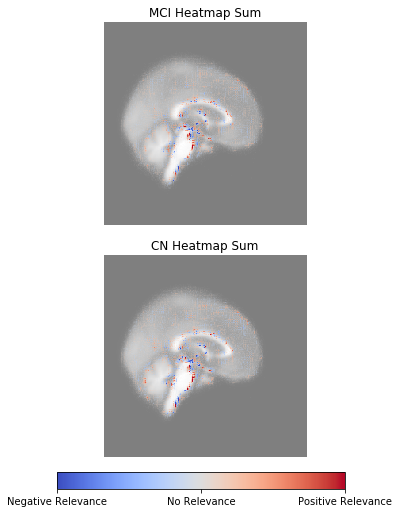

In [23]:
hms = [TP_heatmaps_holdout, TN_heatmaps_holdout]
vmin = -0.01
vmax = 0.01
titles = ["MCI Heatmap Sum", "CN Heatmap Sum"]
plot_heatmap_zero_one(hms, avg_train_image, vmin, vmax, 
                  cmap='TransCoWa', show_average=False,
                  title=titles, file_path=None, show_colorbar=True)

### y axis

In [24]:
all_CN_y = tf.data.TFRecordDataset("y_CN.tfrecords").shuffle(10000,seed=1)
all_MCI_y = tf.data.TFRecordDataset("y_MCI.tfrecords").shuffle(10000,seed=1)

test_CN_y = all_CN_y.take(int(len(CN_files)*0.2)) 
train_CN_y = all_CN_y.skip(int(len(CN_files)*0.2))

test_MCI_y = all_MCI_y.take(int(len(MCI_files)*0.2)) 
train_MCI_y = all_MCI_y.skip(int(len(MCI_files)*0.2))

train_2cls_tra_y= train_MCI_y.concatenate(train_CN_y)
test_2cls_y = test_MCI_y.concatenate(test_CN_y)

train_2cls_tra_y = train_2cls_tra_y.map(decode2).batch(batch_size=50000)
test_2cls_y = test_2cls_y.map(decode2).batch(batch_size = 10000)

iterator_train_y = train_2cls_tra_y.make_initializable_iterator()
features_y,labels_y,names_y = iterator_train_y.get_next()

iterator_test_y = test_2cls_y.make_initializable_iterator()
features_te_y,labels_te_y,names_te_y = iterator_test_y.get_next()

In [25]:
with tf.Session() as sess:
    sess.run(iterator_train_y.initializer)
    sess.run(iterator_test_y.initializer)
    X_train_y,y_train_y = sess.run([features_y, labels_y])
    X_test_y,y_test_y,names_y=sess.run([features_te_y,labels_te_y,names_te_y])

In [26]:
model_path = "model_mcicn_y_trial_0.h5"
model = init_model(model_path, finetune=False, up_to=None)
beheaded_model = replace_classifier(model.layers[-2], activation=None, units=6)
model2 = model.layers[-2]

In [27]:
TP_heatmaps_holdout, TN_heatmaps_holdout = get_heatmap_sum(dataloader=X_train_y, dataloader2=y_train_y ,shape=x.shape, 
                beheaded_model=beheaded_model, prediction_model=model2, mode='prediction', as_list=False)

Sorted by prediction
total 4589
one 2412
zero 2131


/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


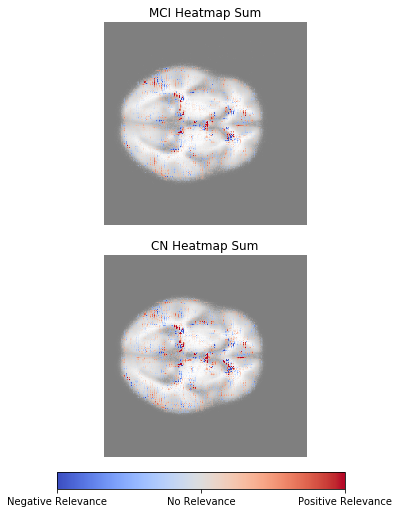

In [28]:
hms = [TP_heatmaps_holdout, TN_heatmaps_holdout]
avg_train_image= np.mean(X_train_y, axis=0)
vmin = -0.01
vmax = 0.01
titles = ["MCI Heatmap Sum", "CN Heatmap Sum"]
plot_heatmap_zero_one(hms, avg_train_image, vmin, vmax, 
                  cmap='TransCoWa', show_average=False,
                  title=titles, file_path=None, show_colorbar=True)

### z axis

In [29]:
all_CN_z = tf.data.TFRecordDataset("z_CN.tfrecords").shuffle(10000,seed=1)
all_MCI_z = tf.data.TFRecordDataset("z_MCI.tfrecords").shuffle(10000,seed=1)

test_CN_z = all_CN_z.take(int(len(CN_files)*0.2)) 
train_CN_z = all_CN_z.skip(int(len(CN_files)*0.2))

test_MCI_z = all_MCI_z.take(int(len(MCI_files)*0.2)) 
train_MCI_z = all_MCI_z.skip(int(len(MCI_files)*0.2))

train_2cls_tra_z= train_MCI_z.concatenate(train_CN_z)
test_2cls_z = test_MCI_z.concatenate(test_CN_z)

train_2cls_tra_z = train_2cls_tra_z.map(decode2).batch(batch_size=50000)
test_2cls_z = test_2cls_z.map(decode2).batch(batch_size = 10000)

iterator_train_z = train_2cls_tra_z.make_initializable_iterator()
features_z,labels_z,names_z = iterator_train_z.get_next()

iterator_test_z = test_2cls_z.make_initializable_iterator()
features_te_z,labels_te_z,names_te_z = iterator_test_z.get_next()

In [30]:
with tf.Session() as sess:
    sess.run(iterator_train_z.initializer)
    sess.run(iterator_test_z.initializer)
    X_train_z,y_train_z = sess.run([features_z, labels_z])
    X_test_z,y_test_z,names_z=sess.run([features_te_z,labels_te_z,names_te_z])

In [31]:
model_path = "model_mcicn_z_trial_0.h5"
model = init_model(model_path, finetune=False, up_to=None)
beheaded_model = replace_classifier(model.layers[-2], activation=None, units=6)
model2 = model.layers[-2]

In [32]:
TP_heatmaps_holdout, TN_heatmaps_holdout = get_heatmap_sum(dataloader=X_train_z, dataloader2=y_train_z ,shape=x.shape, 
                beheaded_model=beheaded_model, prediction_model=model2, mode='prediction', as_list=False)

Sorted by prediction
total 4589
one 2372
zero 2111


/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


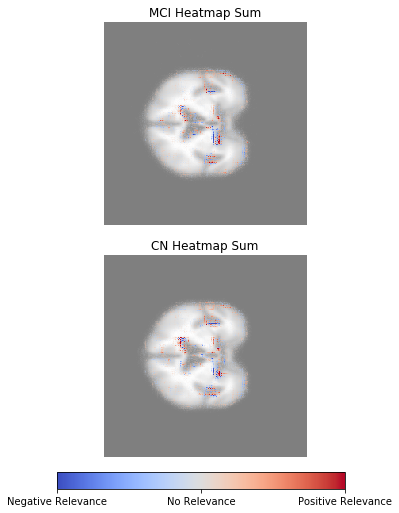

In [33]:
hms = [TP_heatmaps_holdout, TN_heatmaps_holdout]
avg_train_image= np.mean(X_train_z, axis=0)
vmin = -0.01
vmax = 0.01
titles = ["MCI Heatmap Sum", "CN Heatmap Sum"]
plot_heatmap_zero_one(hms, avg_train_image, vmin, vmax, 
                  cmap='TransCoWa', show_average=False,
                  title=titles, file_path=None, show_colorbar=True)